<a href="https://colab.research.google.com/github/phps-28/Data-Science-PGEBM/blob/master/Treinamento_TensorFlow/TF_prj_10_Transfer%C3%AAncia_Aprendizado_Classifica%C3%A7%C3%A3o_Cachorros_Gatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando as Libs

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import zipfile

## Impotando o modelo pré treinado

In [2]:
model =  tf.keras.applications.ResNet50(weights = 'imagenet')

102967424/102967424 [==============================] - 0s 0us/step


## Testando o modelo pré treinado

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/PGEBM/Treinamento_TensorFlow/Transfer-Learning-Data.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall("./")
zip_object.close()

### carregando uma imagem da base baixada para teste

In [5]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/Transfer Learning Data/bicycle.png', target_size = (224, 224))

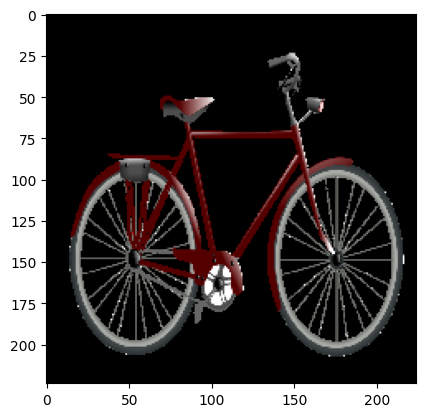

In [6]:
plt.imshow(sample_image);

verificando o tipo do dado da imagem gerada

In [7]:
type(sample_image)

PIL.Image.Image

transformando o tipo do dado da imagem para ficar compatível com o dado que é executado no tensorflow

In [8]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)

In [9]:
type(sample_image)

numpy.ndarray

In [10]:
np.shape(sample_image)

(224, 224, 3)

Adicioando a extensão de 'batch' também necessário para utilizar o tensorflow.

In [11]:
sample_image = np.expand_dims(sample_image, axis = 0)

In [12]:
sample_image.shape

(1, 224, 224, 3)

In [13]:
sample_image.max() # branco

255.0

In [14]:
sample_image.min() # preto

0.0

Fazendo a normalização dos valores dos pixels. A normalização tem que ser compatível com a rede pré treinada. No caso, a ResNet50.

Colocamos a própria `resnet50` para fazer esse pré processamento da imagem para normalizar os seus valores.

In [15]:
sample_image = tf.keras.applications.resnet50.preprocess_input(sample_image)

In [16]:
sample_image.max() # branco

151.061

In [17]:
sample_image.min() # preto

-123.68

## Testando a previsão do modelo pré treinado

In [18]:
predictions = model.predict(sample_image)

1/1 [==============================] - 8s 8s/step


In [19]:
# ".decode_predictions(predictions, top = 5)" -> esse comando vai cruzar a predição com as classes já
# existentes no modelo pré treinado da `resnet50` e trazer a porcentagem das 5 melhores comparações da imagem com as classes do modelo.

print('prediction: ', tf.keras.applications.resnet50.decode_predictions(predictions, top = 5))

35363/35363 [==============================] - 0s 0us/step
prediction:  [[('n02835271', 'bicycle-built-for-two', 0.632961), ('n03792782', 'mountain_bike', 0.053755723), ('n04482393', 'tricycle', 0.049757987), ('n03599486', 'jinrikisha', 0.015690252), ('n04507155', 'umbrella', 0.010513429)]]


## Fazer a Tranferência de Aprendizado e Reuso do Modelo

In [20]:
base_model =  tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)

94765736/94765736 [==============================] - 0s 0us/step


O 'include_top' se refere ao top da rede neural, as camadas densas onde a classificação é feita. Por default, esse parâmetro é 'True' fazendo com que a rede neural inteira essa importada no modelo pré treinado.
Como queremos somente a parte em que houveram os filtros de convolução e pooling da rede, colomaos em 'False' o topo (camadas densas) de classificação, que será personalizado.

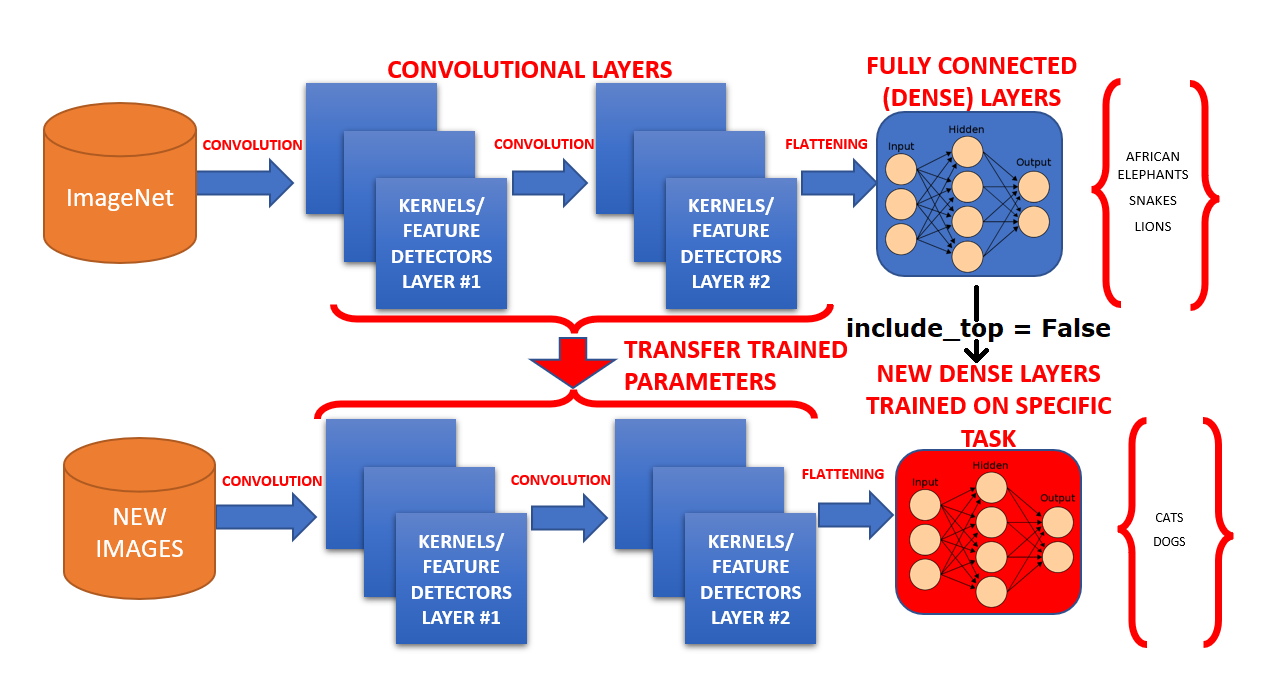

In [21]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

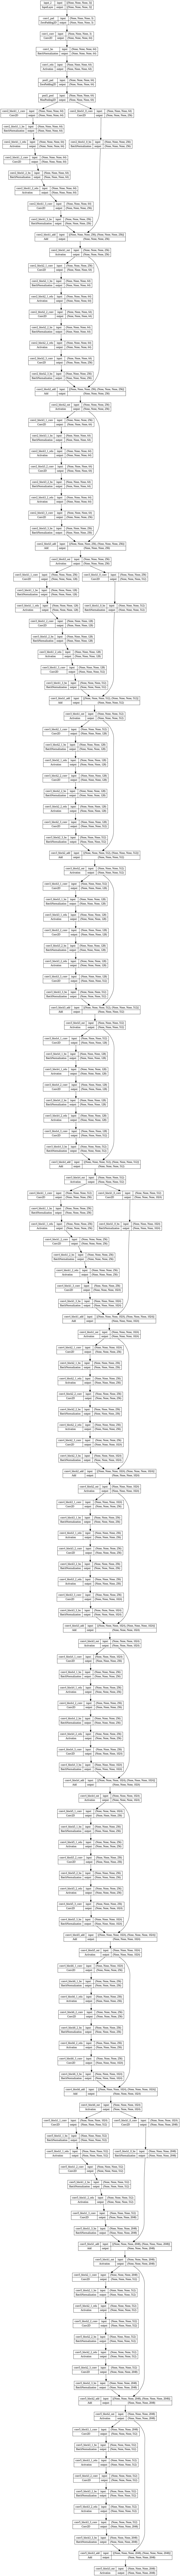

In [22]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

Agora será criada a rede neural Densa, que será personalizada, para juntá-la com essas camadas de convolução e pooling da ResNet 50

In [23]:
x = base_model.output

In [24]:
# Será feito a diminuição da dimensão desta última camada de saída da rede ResNet50 fazedno um pooling com a média dos valores da matriz dos pixels
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [25]:
# Criando as camadas Densas personalizadas
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation='softmax')(x)

In [26]:
# Criando uma modelo que seja a união do modelo pré treinado + as camadas densas personalizadas
model = tf.keras.models.Model(inputs = base_model.input, outputs = preds)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [28]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [30]:
# Como as camadas até a 175 são do modelo que já foi treinado, até a 175 não precisa ser treinada novamente
for layer in model.layers[:175]:
  layer.trainable = False

In [32]:
# serão treinadas as cmadas da 175 em diante, que são as camadas densas personalizadas
for layer in model.layers[175:]:
  layer.trainable = True

In [33]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [35]:
train_generator = train_datagen.flow_from_directory('/content/Transfer Learning Data/train',
                                                    target_size = (224,224),
                                                    color_mode = 'rgb',
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 202 images belonging to 2 classes.


In [37]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
history = model.fit_generator(generator=train_generator,
                              epochs = 10)

Epoch 1/10


<ipython-input-38-8384b24ae74d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


7/7 [==============================] - 7s 278ms/step - loss: 1.4603 - accuracy: 0.6287
Epoch 2/10
7/7 [==============================] - 1s 91ms/step - loss: 0.1301 - accuracy: 0.9703
Epoch 3/10
7/7 [==============================] - 1s 90ms/step - loss: 0.0561 - accuracy: 0.9703
Epoch 4/10
7/7 [==============================] - 1s 107ms/step - loss: 0.1413 - accuracy: 0.9752
Epoch 5/10
7/7 [==============================] - 1s 89ms/step - loss: 0.0099 - accuracy: 0.9950
Epoch 6/10
7/7 [==============================] - 1s 90ms/step - loss: 0.0522 - accuracy: 0.9851
Epoch 7/10
7/7 [==============================] - 1s 90ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 8/10
7/7 [==============================] - 1s 89ms/step - loss: 0.0155 - accuracy: 0.9950
Epoch 9/10
7/7 [==============================] - 1s 89ms/step - loss: 9.2623e-04 - accuracy: 1.0000
Epoch 10/10
7/7 [==============================] - 1s 89ms/step - loss: 3.8913e-04 - accuracy: 1.0000


## Avaliando o Modelo

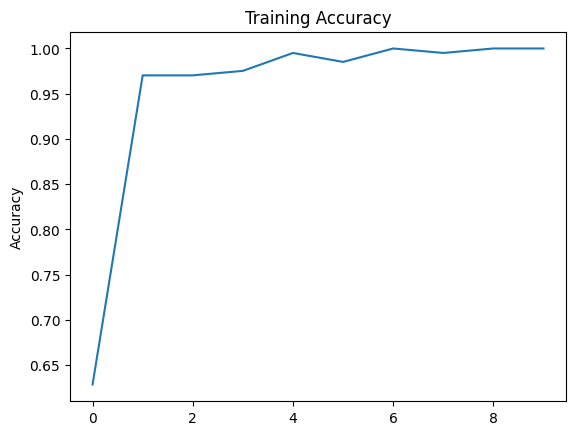

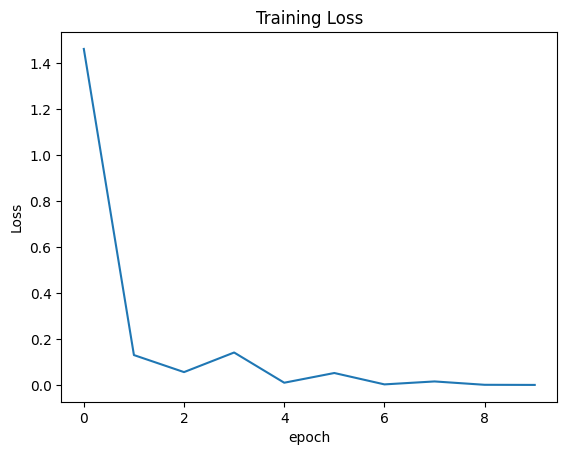

In [39]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

## Testando o novo modelo

In [61]:
image_test = tf.keras.preprocessing.image.load_img(r'/content/Transfer Learning Data/dog.309.jpg', target_size=(224,224))

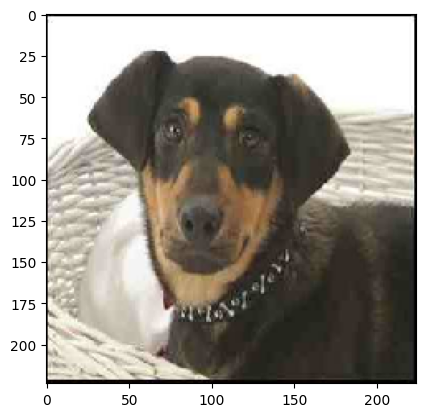

In [62]:
plt.imshow(image_test)

In [63]:
image_test = tf.keras.preprocessing.image.img_to_array(image_test)
np.shape(image_test)

(224, 224, 3)

In [64]:
image_test = np.expand_dims(image_test, axis = 0)
np.shape(image_test)

(1, 224, 224, 3)

In [65]:
image_test = tf.keras.applications.resnet50.preprocess_input(image_test)

In [66]:
predictions = model.predict(image_test)
print(predictions)

1/1 [==============================] - 0s 23ms/step
[[3.5065440e-07 9.9999964e-01]]


In [67]:
cat = float(predictions[0][0])
dog = float(predictions[0][1])
print(f" {100 * cat:.2f}% Cat\n {100 * dog:.2f}% Dog.")

 0.00% Cat
 100.00% Dog.
